#

# LangGraph Agent
This notebook walks through the steps of setting up a simple agent. Although it is basic, it will have the main components including the use of tools and persistent memory.

### 1. Load the needed libraries and environment variables
Unlike most notebooks, I am not going to load all of the imports at the top, but load them where they are needed.

In [12]:
from dotenv import load_dotenv


In [13]:
load_dotenv(override=True)

True

### 2. Add Tools
We will give our agent some access to some tools.  In this case, we are not going to use MCP servers, but instead use LangChain's community tools, which is a robust set of available tools.

Additional details on tools:  https://reference.langchain.com/python/langchain/tools/
Community resource: https://api.python.langchain.com/en/latest/community/

The typical pattern is to find a community resource and then wrap it with a @tool decorator or in this case, create a function that will return a list of tools

In [29]:
from langchain_community.tools import Tool
from langchain_core.tools import BaseTool
from typing import List
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.utilities.wikipedia import WikipediaAPIWrapper
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.agent_toolkits import FileManagementToolkit


def get_tools() -> List[BaseTool]:
    # Define server, wrapper around the Google API, as a tool
    tool_search: Tool = Tool(
        name="search",
        func=GoogleSerperAPIWrapper().run,
        description="Use this tool when you want to get the results of an online web search"
    )

    # Define Wikipedia as a search as a tool
    wikipedia: WikipediaAPIWrapper = WikipediaAPIWrapper()
    wiki_tool: WikipediaQueryRun = WikipediaQueryRun(api_wrapper=wikipedia)

    # Define file management tools
    file_tools: List[BaseTool] = FileManagementToolkit(root_dir="sandbox").get_tools()


    # Concatenate all tools together as a list
    tools: List[BaseTool] = file_tools + [tool_search, wiki_tool]

    return tools

### 3. Setup Memory
LangGraph makes it easy to have persistent memory, but in order be able to retain this memory, we need to define a place to put it.  In this case, we will use SQLite as it is fairly robust for this type of use case.  When building are graph, we will reference this memory.

In [20]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

### 4. Build the Graph
It is now time to put start building the graph.  All graphs include the following steps:
<ol>
<li>Define the State</li>
<li>Start Graph Builder</li>
<li>Create Nodes</li>
<li>Create Edges</li>
<li>Compile the Graph</li>
</ol>

In [30]:
from typing import Annotated
from typing import TypedDict
from langgraph.graph.message import add_messages


# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [31]:
from langgraph.graph import StateGraph

# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [32]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode

# Step 3: Create the nodes.  In this case we have a chatbot and a tool node.
llm = ChatOpenAI(model="gpt-4o-mini")
tools = get_tools()
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [33]:
from langgraph.prebuilt import tools_condition
from langgraph.graph import START

# Step 4: Create the edges
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

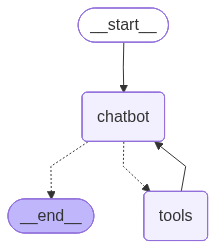

In [34]:
from IPython.display import Image

# Step 5: Compile the graph
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### 5. Test it Out
Use Gradio to create a front end that will allow us to test this out

In [ ]:
import gradio 

memory_key = "jay_123"

config = {"configurable": {"thread_id": memory_key}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gradio.ChatInterface(chat, type="messages").launch()

/Volumes/Storage/Projects/assistant/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Do a report on the battle of 1812 and write it to a file called "battle_of_1812.md"', additional_kwargs={}, response_metadata={}, id='c1b898e6-b3db-4d6f-9886-dc99ebfa9bfa')]}
{'messages': [HumanMessage(content='Do a report on the battle of 1812 and write it to a file called "battle_of_1812.md"', additional_kwargs={}, response_metadata={}, id='c1b898e6-b3db-4d6f-9886-dc99ebfa9bfa'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 428, 'total_tokens': 445, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CcBfrM2DyGmaPuNqLCHwRwAJ8GN3D', 'service_tier': 'default', 'finish_reason': 'tool_calls'